In [1]:
# load all packages
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
import cPickle as pickle
from matplotlib import pyplot as plt
from datetime import datetime
from scipy.optimize import curve_fit
pd.set_option('notebook_repr_html', False)
pd.set_option('display.max_rows', 20)

import matplotlib
matplotlib.rcParams['savefig.dpi'] = 1.25 * matplotlib.rcParams['savefig.dpi']
#from collections import OrderedDict
#from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
#from bokeh.models import HoverTool

from collections import OrderedDict
from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
from bokeh.models import HoverTool

In [2]:
trips_df = pickle.load(open('trips_2014.pickle', 'rb'))
stations_df = pickle.load(open('stations_2014.pickle', 'rb'))
gaptimes_by_bikeid = pickle.load(open('gaptimes_by_bikeid.pickle', 'rb'))
all_gaptimes = pickle.load(open('all_gaptimes.pickle', 'rb'))

print len(trips_df), len(stations_df)

2454634 300


In [3]:
short_gaptimes = all_gaptimes[(all_gaptimes>1) & (all_gaptimes<6)]
print len(short_gaptimes)

def func1(t, tau, A):
    return A*np.exp(-t/tau)
def func2(t, alpha, A):
    return A*alpha*1**alpha/np.power(t,alpha+1)

hist_data = np.histogram(short_gaptimes, bins=25, normed=True)
xs = (hist_data[1][:-1]+hist_data[1][1:])/2
ys = hist_data[0]
popt1, pcov1 = curve_fit(func1, xs, ys, p0=[2.0, 1.0])
print popt1
popt2, pcov2 = curve_fit(func2, xs, ys, p0=[0.2, 3.0])
print popt2
cutoff = (1.0*10**9)**popt2[0]
print cutoff

706544
[ 1.95997315  0.91453733]
[ 0.18759138  3.57237267]
48.789054851


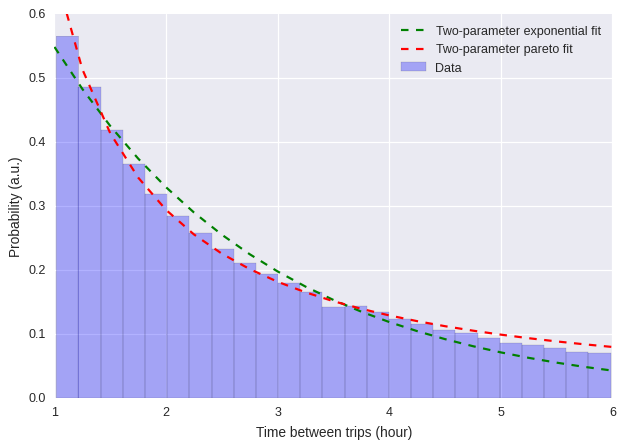

In [4]:
xs0 = np.linspace(1, 6, 21)
plt.plot(xs0, func1(xs0, popt1[0], popt1[1]),'g--', label='Two-parameter exponential fit')
plt.plot(xs0, func2(xs0, popt2[0], popt2[1]),'r--', label='Two-parameter pareto fit')
plt.hist(short_gaptimes, bins=hist_data[1], normed=True, alpha=0.3, color='b', label='Data')
plt.xlim(1, 6)
plt.ylim(0, 0.6)
plt.xlabel('Time between trips (hour)')
plt.ylabel('Probability (a.u.)')
plt.legend(loc='upper right')

In [5]:
bikeids = gaptimes_by_bikeid.keys()
trip_num = trips_df.groupby('bikeid')['tripduration'].count().values
trip_duration = trips_df.groupby('bikeid')['tripduration'].sum().values/3600.0  # in hour
service_num = np.array([len(gaptimes_by_bikeid[bikeid][gaptimes_by_bikeid[bikeid]>cutoff]) for bikeid in bikeids])
service_duration = np.array([gaptimes_by_bikeid[bikeid][gaptimes_by_bikeid[bikeid]>cutoff].sum() for bikeid in bikeids]) # in hour

bikes_df = pd.DataFrame({
        'bikeid': bikeids, 
        'trip_num': trip_num,  # number
        'trip_duration': trip_duration,  # hour
        'service_num': service_num,  # number
        'service_duration': service_duration,  # hour
        'norm_service_num': service_num/trip_duration,  # number per hour
        'norm_service_duration': service_duration/trip_duration,  # dimensionless
    }).set_index('bikeid')

/home/chenyu/anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:604: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


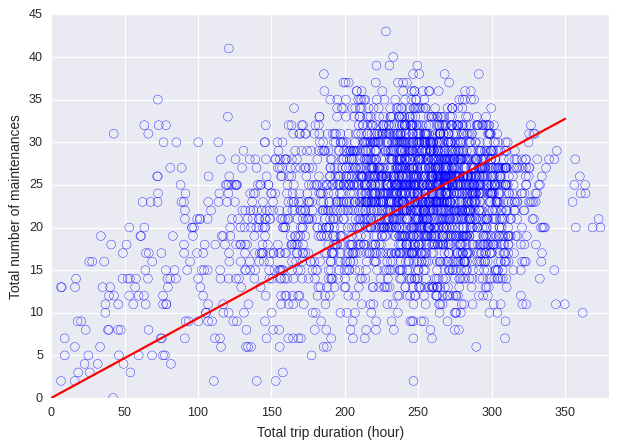

In [6]:
def func0(x, k, b):
    return np.multiply(k, x) + 0*b
popt0, pcov0 = curve_fit(func0, bikes_df.trip_duration.values, bikes_df.service_num)
xs0 = np.linspace(0, 350, 3)
plt.plot(xs0, func0(xs0, popt0[0], popt0[1]), 'r')
plt.xlabel('Total trip duration (hour)')
plt.ylabel('Total number of maintenances')
plt.xlim(0, 380)
plt.ylim(0, 45)
plt.scatter(bikes_df.trip_duration.values, bikes_df.service_num, s=50, facecolors='None', edgecolors='b')

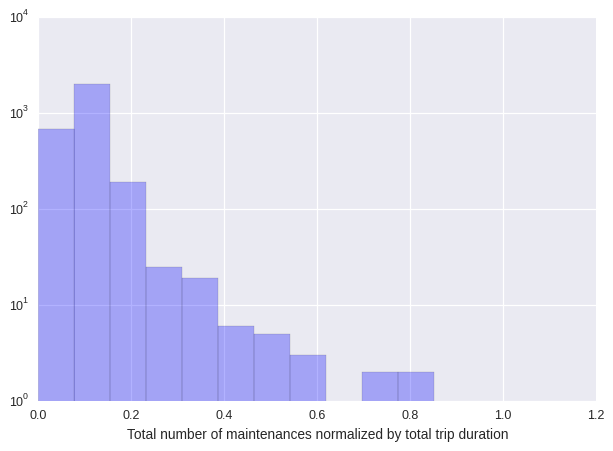

In [7]:
plt.xlim(0, 1.2)
plt.yscale('log')
plt.hist(bikes_df.norm_service_num.values, bins=25, color='b', alpha=0.3)
plt.xlabel('Total number of maintenances normalized by total trip duration')

In [ ]:
stations_df['norm_service'] = 0
for tripid, trip in trips_df.iterrows():
    stations_df.ix[trip.from_station_id].norm_service += bikes_df.ix[trip.bikeid].norm_service_num

In [ ]:
stations_df.norm_service.describe()

In [ ]:
from collections import OrderedDict
from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
from bokeh.models import HoverTool

In [ ]:
lons = stations_df.longitude
lats = stations_df.latitude
names = stations_df.name
colors = ["#%02x%02x%02x" % (r, 150, 150) for r in stations_df.norm_service]

In [ ]:
output_notebook()

TOOLS = "pan, wheel_zoom, box_zoom, reset, hover, save"
source = ColumnDataSource(
    data = dict(
        x = lons,
        y = lats,
        radius = 10,
        name = names,
        color = colors,
    )
)

In [ ]:
p = figure(title="Net Flow Weekday AM Rush Hour", tools=TOOLS)
p.scatter('x', 'y', radius='radius', fill_color='color', fill_alpha=0.5, line_color=None, source=source)
p.xaxis.axis_label = 'Longitude'
p.yaxis.axis_label = 'Latitude'

hover = p.select(dict(type=HoverTool))
hover.point_policy = "follow_mouse"
hover.tooltips = OrderedDict([
    ("Station", "@name"),
])

show(p)

In [ ]:
startdate_by_bike.head(10)
# bike 3044 starts on 9/23/2014!